# Access to F10.7 solar radio flux

> Obective: Daily time series of F10.7 including observations and predictions, over the longest time period available

This notebook demonstrates how to access and process both:
- observed series of F10.7 from Space Weather Canada (observed at Penticton)
- predicted series from NOAA SWPC  
to create a combined time series from 1947 to 2030.

This can be used as input to geomagnetic models (optionally including 81-day averaging)

```mermaid
flowchart LR
 subgraph Observations["Observations"]
    direction LR
        F107_obs["F107_1947_1996.txt<br>F107_1996_2007.txt<br>fluxtable.txt<br>(1-3 measures per day)"]
        F107_obs_process[/"Read<br>Clean outliers<br>Daily median<br>Merge"/]
        SWC(("Space Weather Canada"))
  end
 subgraph Predictions["Predictions"]
    direction LR
        SWPC(("NOAA SWPC"))
        F107_pred["predicted-solar-cycle.json<br>(monthly)"]
        F107_pred_process[/"Read<br>?Adjust?<br>Interpolate"/]
  end
    SWC --> F107_obs
    F107_obs --> F107_obs_process
    SWPC --> F107_pred
    F107_pred --> F107_pred_process
    Observations --> n1[/"Merge"/]
    Predictions --> n1


```

In [1]:
import datetime as dt

import numpy as np
import pandas as pd

Fetch data from Space Weather Canada (original source)

About the data: https://spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-en.php

NB:
- change in sampling rate from daily (1947-1996) to ~3 times per day (1996 onward)
- we will just select the observation at 20:00 UT (local noon) and discard the others, to make a time series sampled once per day
- `fluxtable.txt` provides the most recent available data

In [2]:
datasources = {
    "1947_1996": "https://spaceweather.gc.ca/solar_flux_data/daily_flux_values/F107_1947_1996.txt",
    "1996_2007": "https://spaceweather.gc.ca/solar_flux_data/daily_flux_values/F107_1996_2007.txt",
    "2004_now": "https://spaceweather.gc.ca/solar_flux_data/daily_flux_values/fluxtable.txt",
}

## 1947-1996

This time series is provided once per day (presumably around local noon, 20UT).

In [3]:
# Use fixed-width format parsing since there's at least one row with a missing comma
df_1947_1996 = pd.read_fwf(
    datasources["1947_1996"],
    skiprows=3,
    names=["Julian Date", "Rotation", "Year", "Month", "Day", "Obs.", "Adj.", "URSI-D"],
    dtype=str,
)
df_1947_1996["Julian Date"] = df_1947_1996["Julian Date"].str.strip(",").astype(float)
df_1947_1996["Rotation"] = df_1947_1996["Rotation"].str.strip(",").astype(float)
df_1947_1996["Year"] = df_1947_1996["Year"].str.strip(",").astype(int)
df_1947_1996["Month"] = df_1947_1996["Month"].str.strip(",").astype(int)
df_1947_1996["Day"] = df_1947_1996["Day"].str.strip(",").astype(int)
df_1947_1996["Obs."] = (
    df_1947_1996["Obs."].str.strip(",").astype(float).replace(0, np.nan)
)
df_1947_1996["Adj."] = (
    df_1947_1996["Adj."].str.strip(",").astype(float).replace(0, np.nan)
)
df_1947_1996["URSI-D"] = (
    df_1947_1996["URSI-D"].str.strip(",").astype(float).replace(0, np.nan)
)
df_1947_1996

,Julian Date,Rotation,Year,Month,Day,Obs.,Adj.,URSI-D
0,2432187.20,1248.2754,1947,1,1,NaN,NaN,NaN
1,2432188.20,1248.3120,1947,1,2,NaN,NaN,NaN
2,2432189.20,1248.3485,1947,1,3,NaN,NaN,NaN
3,2432190.20,1248.3851,1947,1,4,NaN,NaN,NaN
4,2432191.20,1248.4217,1947,1,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
17983,2450170.33,1907.6328,1996,3,27,71.8,71.6,64.4
17984,2450171.33,1907.6694,1996,3,28,71.9,71.7,64.5
17985,2450172.33,1907.7060,1996,3,29,70.5,70.3,63.3
17986,2450173.33,1907.7427,1996,3,30,70.2,70.1,63.1


In [4]:
# Construct clean dataframe with just F10.7
df1 = df_1947_1996["Obs."].rename("F107").to_frame()
df1["datetime"] = pd.to_datetime(
    dict(
        year=df_1947_1996["Year"],
        month=df_1947_1996["Month"],
        day=df_1947_1996["Day"],
        hour=20,  # set all measurements to 20:00 UTC (local time noon at Penticton)
    )
)
df1 = df1.set_index("datetime")
df1

,F107
datetime,
1947-01-01 20:00:00,NaN
1947-01-02 20:00:00,NaN
1947-01-03 20:00:00,NaN
1947-01-04 20:00:00,NaN
1947-01-05 20:00:00,NaN
...,...
1996-03-27 20:00:00,71.8
1996-03-28 20:00:00,71.9
1996-03-29 20:00:00,70.5


## 1996-2007

In [5]:
# Load 1996-2007 F10.7 data
df_1996_2007 = pd.read_csv(
    datasources["1996_2007"],
    skiprows=3,
    sep=r"\s+",  # whitespace-delimited
    names=[
        "Julian Day",
        "Carrington Rotation",
        "Year",
        "Month",
        "Day",
        "UT",
        "Observed",
        "Adjusted",
        "Series D",
    ],
    dtype={
        "Julian Day": float,
        "Carrington Rotation": float,
        "Year": int,
        "Month": int,
        "Day": int,
        "UT": int,
        "Observed": float,
        "Adjusted": float,
        "Series D": float,
    },
    usecols=range(
        9
    ),  # only read the first 9 columns (2 extra are introduced later in the file)
    na_values=[".0", "0.0"],  # missing data can be either .0 or 0.0
)
df_1996_2007

,Julian Day,Carrington Rotation,Year,Month,Day,UT,Observed,Adjusted,Series D
0,2450128.250,1906.052,1996,2,14,1800,68.6,66.9,60.2
1,2450128.333,1906.055,1996,2,14,2000,68.9,67.2,60.5
2,2450128.417,1906.058,1996,2,14,2200,69.4,67.7,60.9
3,2450129.250,1906.089,1996,2,15,1800,69.1,67.4,60.7
4,2450129.333,1906.092,1996,2,15,2000,69.0,67.4,60.6
...,...,...,...,...,...,...,...,...,...
12384,2454257.208,2057.434,2007,6,5,1700,90.7,93.4,84.0
12385,2454257.458,2057.444,2007,6,5,2300,86.9,89.5,80.5
12386,2454258.333,2057.476,2007,6,6,2000,87.1,89.7,80.8
12387,2454270.208,2057.911,2007,6,18,1700,66.7,68.8,61.9


In [6]:
def nanmedian(series):
    """Compute the median of a pandas Series, ignoring NaN values."""
    if series.isna().all() or len(series) == 0:
        return np.nan
    return series.median(skipna=True)

In [7]:
# Construct clean dataframe with just *daily* F10.7, calculated by averaging the ~3 daily measurements
df2 = df_1996_2007["Observed"].rename("F107").to_frame()
df2["datetime"] = pd.to_datetime(
    dict(
        year=df_1996_2007["Year"],
        month=df_1996_2007["Month"],
        day=df_1996_2007["Day"],
        # Parse UT as HHMM format (e.g., 1700 for 17:00)
        hour=df_1996_2007["UT"].astype(str).str.zfill(4).str[:2].astype(int),
        minute=df_1996_2007["UT"].astype(str).str.zfill(4).str[2:].astype(int),
    )
)
df2 = df2.set_index("datetime")
# Compute daily median F10.7
df2 = df2.resample("1D").agg(nanmedian)
df2.index = df2.index.map(lambda x: x.replace(hour=20))
df2

,F107
datetime,
1996-02-14 20:00:00,68.90
1996-02-15 20:00:00,69.10
1996-02-16 20:00:00,70.30
1996-02-17 20:00:00,70.70
1996-02-18 20:00:00,70.20
...,...
2007-06-14 20:00:00,NaN
2007-06-15 20:00:00,NaN
2007-06-16 20:00:00,NaN


## 2004 - now

In [8]:
df_2004_now = pd.read_csv(
    datasources["2004_now"],
    skiprows=2,
    sep=r"\s+",  # whitespace-delimited
    names=["date", "time", "julian", "carrington", "obsflux", "adjflux", "ursi"],
    dtype={
        "date": str,  # keep as string for datetime parsing
        "time": str,  # keep as string for datetime parsing
        "julian": float,
        "carrington": float,
        "obsflux": float,
        "adjflux": float,
        "ursi": float,
    },
)
df_2004_now

,date,time,julian,carrington,obsflux,adjflux,ursi
0,20041028,170000,2453307.229,2022.605,132.7,130.9,117.8
1,20041028,200000,2453307.354,2022.610,135.8,134.0,120.6
2,20041029,200000,2453308.354,2022.646,130.6,128.8,115.9
3,20041029,230000,2453308.479,2022.651,134.2,132.3,119.1
4,20041030,170000,2453309.229,2022.678,147.9,145.8,131.2
...,...,...,...,...,...,...,...
23226,20260119,200000,2461060.322,2306.850,173.4,167.9,151.1
23227,20260119,220000,2461060.406,2306.860,173.5,168.0,151.2
23228,20260120,180000,2461061.239,2306.890,179.4,173.8,156.4
23229,20260120,200000,2461061.322,2306.890,177.6,172.0,154.8


In [9]:
df3 = df_2004_now["obsflux"].rename("F107").to_frame()
df3["datetime"] = pd.to_datetime(df_2004_now["date"] + " " + df_2004_now["time"])
df3 = df3.set_index("datetime")
# Compute daily median F10.7
df3 = df3.resample("1D").agg(nanmedian)
df3.index = df3.index.map(lambda x: x.replace(hour=20))
df3

,F107
datetime,
2004-10-28 20:00:00,134.25
2004-10-29 20:00:00,132.40
2004-10-30 20:00:00,140.20
2004-10-31 20:00:00,139.20
2004-11-01 20:00:00,134.75
...,...
2026-01-16 20:00:00,147.50
2026-01-17 20:00:00,157.70
2026-01-18 20:00:00,231.80


## Full observed series

In [10]:
# Combine all datasets and sort by date
df_f107_obs = pd.concat([df1, df2, df3]).sort_index()

# If there are duplicate indices (overlapping dates), keep the newer dataset's values
df_f107_obs = df_f107_obs[~df_f107_obs.index.duplicated(keep="last")]
df_f107_obs

,F107
datetime,
1947-01-01 20:00:00,NaN
1947-01-02 20:00:00,NaN
1947-01-03 20:00:00,NaN
1947-01-04 20:00:00,NaN
1947-01-05 20:00:00,NaN
...,...
2026-01-16 20:00:00,147.5
2026-01-17 20:00:00,157.7
2026-01-18 20:00:00,231.8


<Axes: xlabel='datetime'>

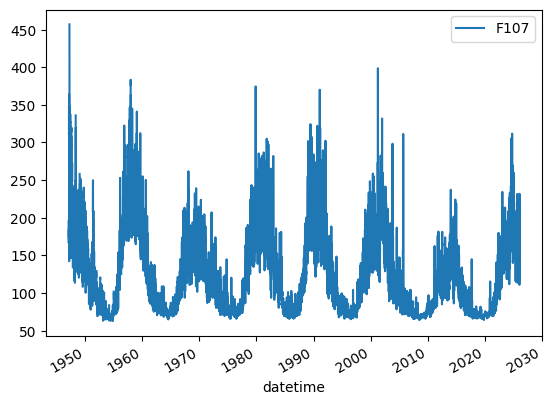

In [11]:
df_f107_obs.plot()

## Cleaned time series

- Remove outliers
- Infill gaps with NaN
- **TODO:**
  - **Decide if we should use this outlier cleaning procedure**
    - Compare with CHAOS model input data procedure: "Flux values were averaged using the median of each day, after removing missing observations (0 sfu) or extreme values (>10000 sfu) from the input data.”

In [12]:
# https://gitlab.com/KNMI-OSS/spaceweather/swxtools/-/blob/main/src/swxtools/access/penticton_f10.py#L55
def list_outliers(df_in, field="F107", multiplier=3, threshold=20):
    """Provide list of dates of outliers that differ from the median over a
    5-day window by a threshold, as well as a multiplier times the standard
    deviation over an 81-day window"""
    df = df_in.copy()
    df["5d_median"] = df[field].rolling("5D").median()
    df["81d_std"] = df[field].rolling("81D").std()
    df["5d_diff"] = df[field] - df["5d_median"]
    outlier_dates = df.index[
        (df["5d_diff"] > threshold) & (df["5d_diff"] > multiplier * df["81d_std"])
    ]
    return outlier_dates


def clean(df):
    return df.drop(list_outliers(df))

<Axes: title={'center': 'Cleaned F10.7 Data'}>

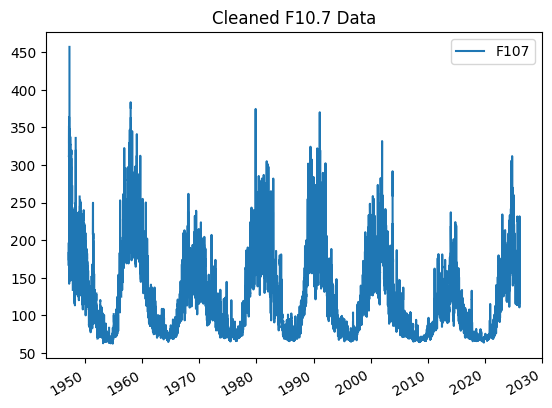

In [13]:
# Remove outliers
df_f107_clean = clean(df_f107_obs)
# Fill missing dates with NaN
df_f107_clean = df_f107_clean.reindex(
    pd.date_range(df_f107_clean.index.min(), df_f107_clean.index.max())
)
df_f107_clean.plot(title="Cleaned F10.7 Data")

In [14]:
df_f107_clean

,F107
1947-01-01 20:00:00,NaN
1947-01-02 20:00:00,NaN
1947-01-03 20:00:00,NaN
1947-01-04 20:00:00,NaN
1947-01-05 20:00:00,NaN
...,...
2026-01-16 20:00:00,147.5
2026-01-17 20:00:00,157.7
2026-01-18 20:00:00,231.8
2026-01-19 20:00:00,173.4


<Axes: >

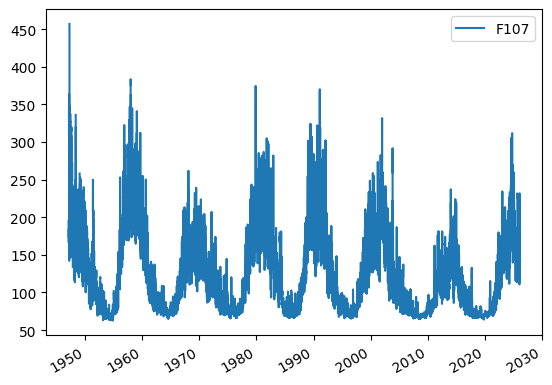

In [15]:
df_f107_clean.plot()

## Forecast / predicted series

Sources for predictions:
- https://www.swpc.noaa.gov/products/solar-cycle-progression
- ... should we consider any other sources?

In [16]:
datasources_pred = {
    "noaa_swpc": "https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json",
}

In [17]:
df_f107_pred_in = pd.read_json(datasources_pred["noaa_swpc"])

Note:
- These are monthly prediction values rather than daily
- **TODO:**
  - **find out if "predicted_f10.7" is indeed F10.7 at Earth (not the "adjusted value", which is standardised to a fixed 1AU distance from the Sun)**
  - **Should we assume the value is valid at the midpoint of the month? or the start of the month?**

In [18]:
df_f107_pred_in

,time-tag,predicted_ssn,high25_ssn,high_ssn,high75_ssn,low25_ssn,low_ssn,low75_ssn,predicted_f10.7,high25_f10.7,high_f10.7,high75_f10.7,low25_f10.7,low_f10.7,low75_f10.7
0,2025-07,123.9,130.4,134.8,141.2,118.3,114.4,110.7,155.3,160.2,163.5,168.3,151.0,148.0,145.3
1,2025-08,123.3,130.2,134.6,140.8,117.6,113.7,110.1,153.1,158.3,161.6,166.3,148.8,145.8,143.1
2,2025-09,121.0,128.1,132.4,138.7,115.6,111.7,108.1,151.0,156.4,159.7,164.4,146.9,144.1,141.3
3,2025-10,120.1,127.0,131.4,137.8,114.9,111.2,107.8,150.4,155.7,158.9,163.8,146.5,143.6,141.1
4,2025-11,118.5,125.4,129.8,135.8,113.5,109.9,106.6,149.8,154.9,158.3,162.8,145.9,143.2,140.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2030-08,11.1,18.0,20.2,26.4,2.7,0.0,0.0,71.5,74.7,75.8,78.9,68.0,67.8,67.8
62,2030-09,10.3,16.2,18.2,24.4,0.9,0.0,0.0,71.2,73.9,74.8,77.9,67.8,67.8,67.8
63,2030-10,9.6,14.8,16.6,22.9,0.0,0.0,0.0,71.0,73.3,74.1,77.2,67.8,67.8,67.8
64,2030-11,9.0,13.4,15.0,21.6,0.0,0.0,0.0,70.7,72.7,73.4,76.6,67.8,67.8,67.8


In [19]:
df_f107_pred = df_f107_pred_in[["time-tag", "predicted_f10.7"]].rename(
    columns={"predicted_f10.7": "F107", "time-tag": "datetime"}
)
df_f107_pred["datetime"] = pd.to_datetime(df_f107_pred["datetime"])
df_f107_pred = df_f107_pred.set_index("datetime")
df_f107_pred

,F107
datetime,
2025-07-01,155.3
2025-08-01,153.1
2025-09-01,151.0
2025-10-01,150.4
2025-11-01,149.8
...,...
2030-08-01,71.5
2030-09-01,71.2
2030-10-01,71.0


<Axes: title={'center': 'Predicted F10.7 Data'}, xlabel='datetime'>

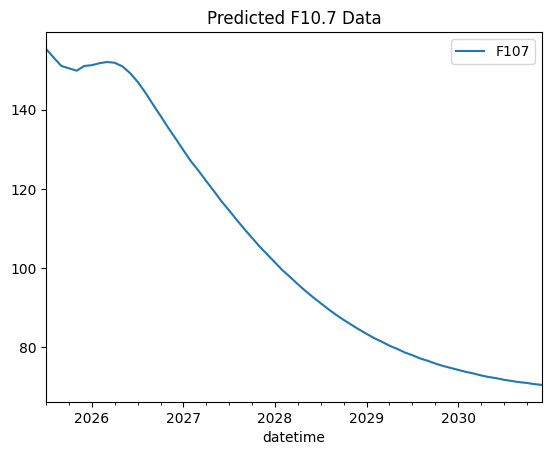

In [20]:
df_f107_pred.plot(title="Predicted F10.7 Data")

### Compare predictions with observations

In [21]:
months_overlapping = (
    df_f107_clean.index.to_period("M")
    .intersection(df_f107_pred.index.to_period("M"))
    .to_timestamp()
)

for date in months_overlapping:
    print(f"Month {date.year}-{date.month}:")
    predicted = float(df_f107_pred.loc[f"{date.year}-{date.month:02d}-01"].F107)
    print(f"predicted: {predicted}")
    observed = float(((df_f107_clean.loc[f"{date.year}-{date.month}"]).mean().F107))
    print(f"observed (mean over month): {observed:.2f}\n")

Month 2025-7:
predicted: 155.3
observed (mean over month): 137.72

Month 2025-8:
predicted: 153.1
observed (mean over month): 153.95

Month 2025-9:
predicted: 151.0
observed (mean over month): 153.97

Month 2025-10:
predicted: 150.4
observed (mean over month): 139.55

Month 2025-11:
predicted: 149.8
observed (mean over month): 140.94

Month 2025-12:
predicted: 151.0
observed (mean over month): 160.15

Month 2026-1:
predicted: 151.2
observed (mean over month): 147.44



## Combined series

Let's adjust the predicted time series to the 15th of each month (approx middle), then use a linear interpolation to fill in daily values.

In [22]:
df_f107_pred_infilled = df_f107_pred.copy()
# Adjust index to the 15th of each month at 20:00 UTC
df_f107_pred_infilled.index = df_f107_pred_infilled.index.map(
    lambda x: x.replace(day=15, hour=20)
)
# Select out predictions starting from after the last observed date
start_predictions = df_f107_clean.index[-1] + dt.timedelta(days=1)
end_predictions = df_f107_pred_infilled.index[-1]
df_f107_pred_infilled = df_f107_pred_infilled.loc[slice(start_predictions, None)]
# Fill in missing dates with NaN
df_f107_pred_infilled = df_f107_pred_infilled.reindex(
    pd.date_range(start_predictions, end_predictions, freq="D")
)
# Interpolate to fill in daily values
df_f107_pred_infilled = df_f107_pred_infilled.interpolate(method="linear")
df_f107_pred_infilled

,F107
2026-01-21 20:00:00,NaN
2026-01-22 20:00:00,NaN
2026-01-23 20:00:00,NaN
2026-01-24 20:00:00,NaN
2026-01-25 20:00:00,NaN
...,...
2030-12-11 20:00:00,70.526667
2030-12-12 20:00:00,70.520000
2030-12-13 20:00:00,70.513333
2030-12-14 20:00:00,70.506667


In [23]:
# Combine cleaned observed data with infilled predicted data; perform final interpolation to fill any remaining gaps
df_f107_combined = pd.concat([df_f107_clean, df_f107_pred_infilled])
df_f107_combined = df_f107_combined.interpolate(method="linear")

<Axes: title={'center': 'Combined F10.7 Data + Predictions'}>

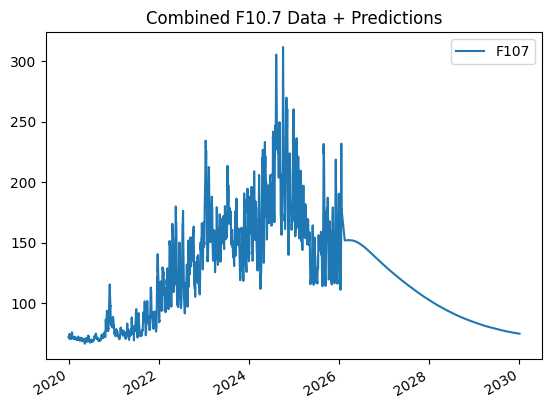

In [24]:
df_f107_combined.loc[slice("2020-01-01", "2030-01-01")].plot(
    title="Combined F10.7 Data + Predictions"
)

<Axes: title={'center': 'Predictions from last observed date'}>

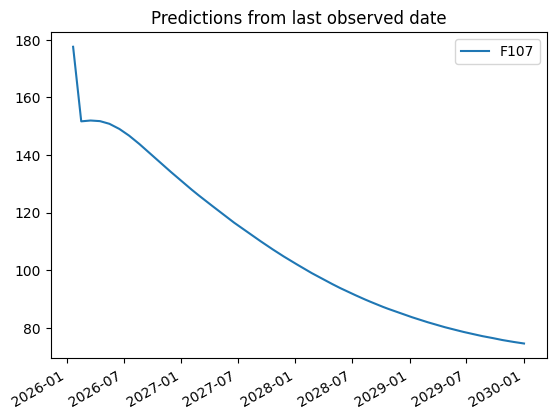

In [25]:
df_f107_combined.loc[slice(df_f107_clean.index[-1], "2030-01-01")].plot(
    title="Predictions from last observed date"
)

- **TODO:**
  - **How should the interpolation be done across gaps and across the boundary to the prediction?**

## Input for models

Some Swarm models (targeting mid-latitude ionosphere) expect 81-day smoothed F10.7 values as input:

- [`SW_MIO_SHA_2C`](https://swarmhandbook.earth.esa.int/catalogue/sw_mio_sha_2c)
- [`SW_MIO_SHA_2D`](https://swarmhandbook.earth.esa.int/catalogue/sw_mio_sha_2d)

Others (targeting polar ionosphere) expect the instantaneous daily value(?):
- [`AMPS / SW_MIO_SHA_2E`](https://swarmhandbook.earth.esa.int/catalogue/sw_mio_sha_2e) (also needs IMF)
- CHAOS-8 MIO (also needs IMF)

*In VirES, these are stored as auxiliary variables, `F107` and `F107_avg81d`*

References:
- Sabaka, T.J., Tøffner-Clausen, L., Olsen, N. et al. CM6: a comprehensive geomagnetic field model derived from both CHAMP and Swarm satellite observations. Earth Planets Space 72, 80 (2020). https://doi.org/10.1186/s40623-020-01210-5
- Kloss, C., Finlay, C. C., Olsen, N., Tøffner-Clausen, L., Gillet, N., & Grayver, A. (2025). CHAOS-8 geomagnetic field model (8.4). Zenodo. https://doi.org/10.5281/zenodo.17225475
- Laundal, K. M., Finlay, C. C., Olsen, N., & Reistad, J. P. (2018). Solar wind and seasonal influence on ionospheric currents from Swarm and CHAMP measurements. Journal of Geophysical Research: Space Physics, 123, 4402–4429. https://doi.org/10.1029/2018JA025387 

### Input for CHAOS & AMPS

- ***Should the outliers be screened out like we did here? Any other processing to apply?***
- ***Do we use the daily instantaneous value rather than the 81-day smoothed value?***
- ***Should we use the same processing for both AMPS & CHAOS? Is this likely to change in the future?***

#### CHAOS

- https://www.spacecenter.dk/files/magnetic-models/CHAOS-8/latest.html
- File contains processing detail in CDF HEADER:  
  https://www.spacecenter.dk/files/magnetic-models/CHAOS-8/_downloads/96a10044ebb5bcf4a83e8cc4fdc6b004/F107_1day_19960101T120000_20250910T120000_0804.cdf

In [26]:
import astropy.time as atime
import pooch
import pycdfpp
import xarray as xr

In [27]:
chaos_f107_sample_file = pooch.retrieve(
    "https://www.spacecenter.dk/files/magnetic-models/CHAOS-8/_downloads/96a10044ebb5bcf4a83e8cc4fdc6b004/F107_1day_19960101T120000_20250910T120000_0804.cdf",
    known_hash="a29365875acd8cb2ca08ea51610c1663c0426e788eb28f3b4105610cff95ca0b",
)

In [28]:
pycdfpp.load(chaos_f107_sample_file)

CDF:
  version: 3.7.0
  majority: row
  compression: None

Attributes:
  HEADER: "Observed solar radio flux at 10.7 cm at daily resolution, given in solar flux units sfu = 10^-22 W m^-2 Hz^-1. Flux values were averaged using the median of each day, after removing missing observations (0 sfu) or extreme values (>10000 sfu) from the input data. These data were accessed via the LASP Interactive Solar Irradiance Datacenter (LISIRD) (https://lasp.colorado.edu/lisird/data/penticton_radio_flux) and collected by the Solar Radio Monitoring Program (https://www.spaceweather.gc.ca/forecast-prevision/solar-solaire/solarflux/sx-en.php), operated by the National Research Council and Natural Resources Canada."

Variables:
  Time: [ 10828 ], [CDF_DOUBLE], record vary:True, compression: GNU GZIP
  F107: [ 10828 ], [CDF_DOUBLE], record vary:True, compression: GNU GZIP


_"Flux values were averaged using the median of each day, after removing missing observations (0 sfu) or extreme values (>10000 sfu) from the input data."_

In [29]:
def mjd2000_to_datetime(mjd2000_array):
    mjd_array = mjd2000_array + 51544.5  # Convert MJD2000 to MJD
    return atime.Time(mjd_array, format="mjd").to_datetime()


def cdf_to_xarray(cdf, timevar="Time", parse_mjd2000_time=True):
    data_dict = {varname: data.values for varname, data in cdf.items()}
    timevar = timevar if timevar in cdf else None
    if not timevar:
        raise ValueError(f"{timevar} is not in the dataset")
    ds = xr.Dataset()
    for varname, data in data_dict.items():
        num_dims = len(data.shape)
        dim_names = [timevar] + [f"{varname}_dim_{i}" for i in range(1, num_dims)]
        ds[varname] = dim_names, data
    if parse_mjd2000_time and timevar:
        ds[timevar] = mjd2000_to_datetime(ds[timevar].values)
    return ds


f107_chaos_sample = cdf_to_xarray(pycdfpp.load(chaos_f107_sample_file)).to_pandas()
print("CHAOS input sample data")
f107_chaos_sample

CHAOS input sample data


,F107
Time,
1996-01-02,75.1
1996-01-03,74.8
1996-01-04,80.8
1996-01-05,85.9
1996-01-06,84.9
...,...
2025-09-07,144.0
2025-09-08,129.9
2025-09-09,124.6


- *Why are the two time series misaligned by one day?*
  - An error in converting time formats?
  - or just because of realigning "1996-01-02 20:00:00" to "1996-01-03 00:00:00"?
  - or have we made an error in the UT assignation in our pipeline?

In [30]:
print("F107 from our pipeline")
df_f107_combined.loc[slice("1996-01-02", "2025-09-11")]

F107 from our pipeline


,F107
1996-01-02 20:00:00,74.8
1996-01-03 20:00:00,80.8
1996-01-04 20:00:00,85.9
1996-01-05 20:00:00,84.9
1996-01-06 20:00:00,82.7
...,...
2025-09-07 20:00:00,129.9
2025-09-08 20:00:00,124.6
2025-09-09 20:00:00,121.7
2025-09-10 20:00:00,118.5


### Smoothed inputs for MIO_SHA_2C etc

- Use a 81-day average

<Axes: >

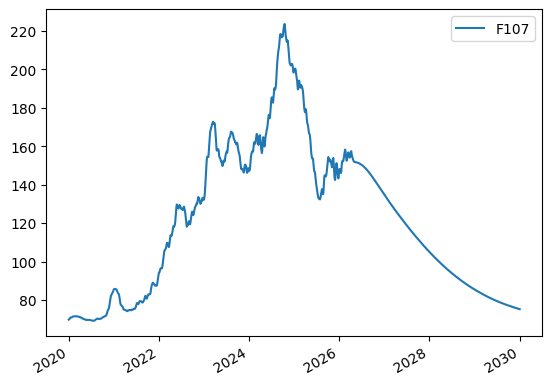

In [31]:
df_f107_combined_avg81d = df_f107_combined.rolling(window="81D", center=False).mean()
df_f107_combined_avg81d.loc["2020-01-01":"2030-01-01"].plot()